# Line-by-line cheap neurodream

Like a 1D cellular automaton, but about networks

### ToDo:

* OK, now maybe blur the training image just a little bit, to trick the model into sharpening its output?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from IPython.display import display
import tensorflow as tf
import itertools

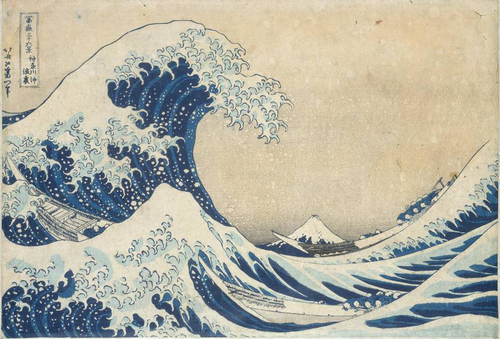

In [2]:
# Read and transform some image
def load_image(i=0, targetSize=(100,200), bw=False):
    """Load i-th image from the input folder.    
    targetSize: will be downsampled to this (y,x). The smallest of dimensions defines the output size.
    """
    inFolder = '../pics-in/'
    fileList = os.listdir(inFolder)
    fileName = inFolder + fileList[i] # Read the first image alphabetically, for now
    # print(fileName)
    im = Image.open(fileName)

    im.thumbnail(targetSize, Image.ANTIALIAS)
    if bw:
        im = im.convert('L') # 1 for BW dither; L for grayscale; LAB and HSV may be interesting for the future
    else:
        im = im.convert('RGB')
    # display(im) # Faithful representation
    return im

class Const():
    i = None
    modelName = ''
    h = None
    w = None

c = Const()
c.i = 1
im = load_image(c.i , (500,500), bw=False) # ~600 px works well

# plt.imshow(im); # Mathy representation: grayscales get pseudocolored, scaled to fig size
display(im) # Show the real size of it

In [3]:
def im_to_numpy(im):
    """Gets and saves image dimensions."""
    x = np.array(im) # BW images are H*W, whiel color are also *3
    if len(x.shape)==3:
        c.color = True
        (c.h , c.w, _) = x.shape # No need to return this, as C is global
    else: 
        c.color = False
        (c.h , c.w) = x.shape # No need to return this, as C is global
        x = np.expand_dims(x, 2)    # To make  it compatible with color image pipeline
    c.data_mean = np.mean(x, axis=(0,1))
    c.data_std =  np.std(x, axis=(0,1))
    x = (x-c.data_mean)/c.data_std
    return x
    
def roll_image(x,n=1):
    i = list(range(n,c.w))+list(range(n))
    out = x[:,i,:]
    return out

def prep_model_inputs(pic_in, pic_out):
    temp =  np.rollaxis(pic_in,1,0)
    y = np.rollaxis(pic_out,1,0) # Flip x and y

    x = np.zeros((c.w-c.thick+1, c.thick, c.h, 3))
    for i in range(c.w-c.thick+1):
        x[i,:,:,:] = temp[[range(i, c.thick+i)],:,:]
    y = y[:-c.thick+1,:,:]
    return x,y

c.thick = 3 # Now many lines to use for predicting the next one. Should be >=2

# In this case both x and y are images (just different parts of it)
pic_in = im_to_numpy(im)
pit_out = roll_image(pic_in, c.thick)    # Shift by one column
x,y = prep_model_inputs(pic_in, pit_out)

print('X shape:',x.shape)
print('Y shape:',y.shape)

X shape: (498, 3, 339, 3)
Y shape: (498, 339, 3)


In [4]:
# Create a static dataset:
d = tf.data.Dataset.from_tensor_slices((x, y))
print(d)

# Now turn it into an iterator:
d = d.shuffle(100, reshuffle_each_iteration=True).batch(4) # 4 sets the batch size
print(d)

<TensorSliceDataset shapes: ((3, 339, 3), (339, 3)), types: (tf.float64, tf.float64)>
<BatchDataset shapes: ((None, 3, 339, 3), (None, 339, 3)), types: (tf.float64, tf.float64)>


In [7]:
def build_model(c):
    my_size = 11   # How many pixels to both sides to see
    my_depth = 128 # Depth of the post-convolution dense network
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(my_depth, kernel_size=(c.thick, my_size), activation='relu', 
                               padding='same', input_shape=(c.thick, c.h, 3),
                               kernel_regularizer=tf.keras.regularizers.l1(0.01)),
        tf.keras.layers.Conv2D(my_depth, kernel_size=(c.thick, 7), activation='relu', padding='same',
                              kernel_regularizer=tf.keras.regularizers.l1(0.01)),
        tf.keras.layers.MaxPooling2D(pool_size=(c.thick, 1), padding='same'),
        tf.keras.layers.Reshape((c.h, my_depth)),
        #tf.keras.layers.MaxPooling1D(pool_size=5, padding='same'),
        tf.keras.layers.Conv1D(my_depth // 4 , my_size, activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(0.02)),
        tf.keras.layers.Conv1D(my_depth // 16 , my_size, activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(0.02)),
        tf.keras.layers.Conv1D(my_depth // 32, my_size, activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(0.02)),
        #tf.keras.layers.MaxPooling1D(pool_size=5, padding='same'),
        tf.keras.layers.Conv1D(3, my_size, activation='linear', padding='same')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mse'])
    
    return (model,c)

(model,c) = build_model(c)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 339, 128)       12800     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 339, 128)       344192    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 339, 128)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 339, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 339, 32)           45088     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 339, 8)            2824      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 339, 4)           


....................................................................................................

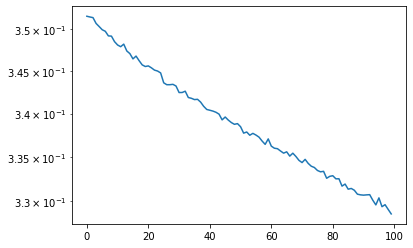

In [22]:
# Train the model:

class PrintDot(tf.keras.callbacks.Callback): # Copied from the manual; is called after each epoch
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')


history = model.fit(d, epochs=100, verbose=0, callbacks=[PrintDot()], shuffle=True)

ax = plt.axes()
ax.plot(history.history['loss'])
ax.set_yscale('log')

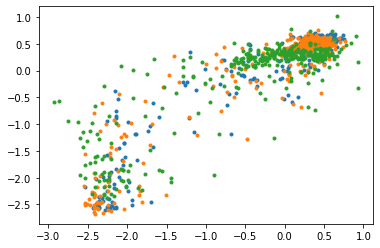

In [23]:
# Reconstruct one line of an image, to test correlation
def wrap(t):
    return t.reshape((1,) + t.shape).astype(float) # Some hacking to match the batch-defined dimensions of the model

one_guess = model.predict(wrap(x[0,:,:,:]),steps=1)
one_guess = np.squeeze(one_guess)

plt.plot(x[c.thick, 0, :, :],one_guess,'.');

In [12]:
im2 = None
# To make possible sequential running of next cell

><

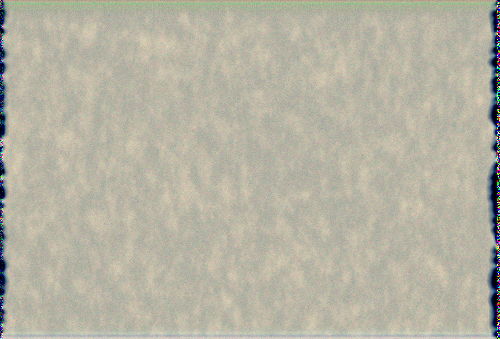

In [14]:
def generate_image(model, nruns=1, mix_k=0.5, seed=None, control_variance=False):
    """Generate an image from a seed of 1-2 rows"""
    if seed is None:
        y = np.random.normal(size=(c.w , c.h , 3))
    else:
        y = np.array(seed)
        y = np.rollaxis(y, 1, 0)
        y = y-np.mean(y, axis=(0,1))
        y = y/np.std(y, axis=(0,1))
        
    for i_run in range(nruns):
        if i_run % 2 == 0:
            direction = 1
            sequence = range(c.w)
            print('>', end='')
        else:
            direction = -1
            sequence = range(c.w-1,-1,-1)
            print('<', end='')
        for i in sequence:
            if (direction==1 and i<c.thick) or i>c.w-c.thick-1:
                col = y[i,:,:]
            else:
                if direction==1:
                    col = model.predict(wrap(y[(i-c.thick):i,   :,:]), steps=1) 
                else:
                    col = model.predict(wrap(y[(i+c.thick):i:-1,:,:]), steps=1) 
                # Dim: (2, 370, 3) before wrapping; (1, 2, 370, 3) after
                col = np.squeeze(col)
            if control_variance:
                pass # add normalization here
            y[i,:,:] = y[i,:,:]*(1-mix_k) + col*mix_k
        
        y = y-np.mean(y, axis=(0,1))
        y = y/np.std(y, axis=(0,1))
        
    y = y*c.data_std + c.data_mean
    y = np.maximum(0, np.minimum(y,255))
    y = np.rollaxis(y, 1, 0)

    img = Image.fromarray(np.uint8(y),"RGB") # Without this weird uint8 type-casting, doesn't work
    img = img.convert('RGB')
    return img
    
#ground = im_to_numpy(im)
im2 = generate_image(model, seed=im2, nruns=2, mix_k=0.75)
display(im2)

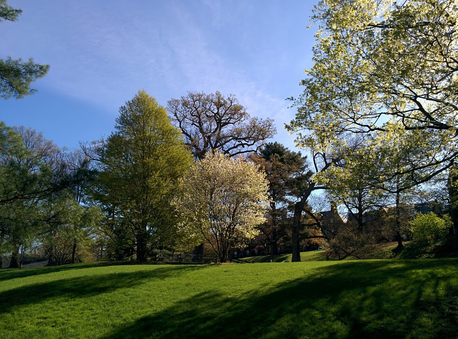

0


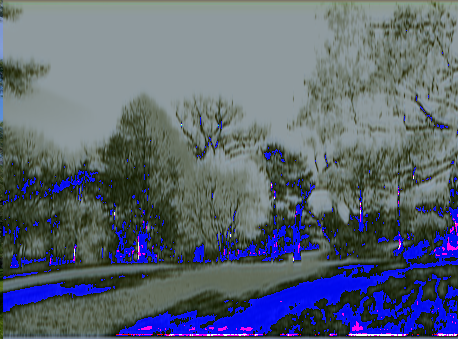

1


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x000001CD36F884C8>
Traceback (most recent call last):
  File "C:\Users\khakh\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\data\ops\iterator_ops.py", line 537, in __del__
    handle=self._handle, deleter=self._deleter)
  File "C:\Users\khakh\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\ops\gen_dataset_ops.py", line 1139, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


In [ ]:
def transform_image(ground, model, mix=1):
    """Predict one image from another"""
    m = np.mean(ground, axis=(0,1))
    s = np.std(ground, axis=(0,1))
    y = np.zeros((c.h , c.w , 3))
    for i in range(c.w):
        if i<c.thick:
            col = (ground[:,i,:]-m)/s
        else:
            seed = np.rollaxis((ground[:,range(i-c.thick, i),:]-m)/s, 1, 0)
            # Need to get to dimensions (2, 370, 3)
            col = model.predict(wrap(seed),steps=1)
            col = np.squeeze(col)
        
        y[:,i,:] = col*c.data_std + c.data_mean
        
    if mix<1:
        y = y*mix + ground*(1-mix)

    img = Image.fromarray(np.uint8(y),"RGB") # Without this weird uint8 type-casting, doesn't work
    img = img.convert('RGB')
    return img

im3 = load_image(0 , (1000, c.h)) # 2nd dimension should exactly match that of the training image
display(im3)
for q in range(7):
    print(q)
    im3 = transform_image(im_to_numpy(im3), model, mix=1)
    if q % 3 ==0:
        display(im3)